# 4) ML Project - Air Pollution - Refined ML Models 

<font color='blue'> Scripts by Kevin Jeswani, Junaid Zafar, & Laiba Shah 
<br>
WeCloudData Bootcamp 2022 (Part-time Cohort)<br> </font>

First we take a look at a dataset for air pollutions deaths due over time for different countries. We visualize data and develop the linear regression models on the regional and national level. The linear regression models are valuable at predicting the general trend in deaths due over time and be used to predict future deaths, where past data appears to be highly linear. It has severe limitations for many countries. Polynomial models could be explored. To explore the interaction with other features, we proceed to merge different datasets between death due to environmental factors and socio-demographic/economic factors. We then examine them in 3 tree-based machine learning models.

The set of scripts in the folder 'AirPollution_Scripts' are segmented for the purpose of clarity & convenience <br>
The following is the suggested order for running the scripts:
- 'MLProject_AirPollution_Viz_LR.ipynb'  - loading the initial Kaggle air pollution deaths dataset, processing, visualizing the base dataset, linear regression examination and future predictions.
- 'MLProject_DataProcessing_OECD_WB_GBD.ipynb' - loading raw data from world bank and GBD/OECD datasets, cleaning, and merging usable data. We test the use of fuzzy data set merging.
- 'MLProject_Exploratory_ML_Models.ipynb' - loading the cleaning & merged dataset, testing out KNN regressor, and model selection with PyCaret, and discussion of models/insights in modelling data.
- 'MLProject_ML_Models_refined.ipynb' **This Script**- development of selected machine learning models (Extra Trees, Random Forest, XGBoost), cross-validation, & Ensemble methods; discussion of model results

The aim is to explore the intial dataset (https://www.kaggle.com/datasets/akshat0giri/death-due-to-air-pollution-19902017?resource=download), supplement it, infer trends, and make predictions on future deaths due to environmental factors. 
The data is then supplement with:
- Global Burden of Disease Study 2019 Results via OECD.stats: https://stats.oecd.org/index.aspx?lang=en# (where the Kaggle dataset seems to have extracted and cleaned data from)
- World Bank Development Indicators: https://databank.worldbank.org/source/world-development-indicators#
<br>

## 1.0 Pre-processing

### 1.1 Standard Imports

In [1]:
#compare voting ensemble to each model for regression as tested above

from matplotlib import pyplot

In [2]:
#Data Processing
import numpy as np #
from numpy import mean, std, absolute
import numexpr #numerical expression eval

import category_encoders as ce 
import pandas as pd
import csv

#Plotting
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
sns.set()


#Machine Learning
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, KFold #Training & Testing / Cross Validation
#from sklearn.preprocessing import StandardScaler # for data scaling
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, VotingRegressor #Ensemble methods
from sklearn.metrics import r2_score, mean_absolute_error, f1_score, mean_squared_error as MSE #Regression metrics
import statsmodels

#XGBoost
import xgboost
from xgboost import XGBRegressor

## 2.0 Data Examination & Processing

In [3]:
# Input your local directories here - everything else is parametric
root = r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts'
root_raw=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Raw Data'
root_proc=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Processed'
root_plots=r'C:\Users\kevin\Documents\WCD_Bootcamp\ML\ML_Project\Scripts\Plots'

### 2.1 Load Data into DF & Examine Contents

In [6]:
fid = '\MergedData_EnvDeaths_GDP_Pop_Income_SoDI_2.csv'
dtypes = {'Population':'float','GDP_pCapita':'float'} #specify data types as required
df_in = pd.read_csv(root_proc+fid,dtype=dtypes)
df_in=df_in.drop(['Unnamed: 0'],axis=1) #drop excess index column

#Display Properties
heading_properties = [('font-size', '8px')]
cell_properties = [('font-size', '6px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

df_in.style.set_table_styles(dfstyle)

### 2.3 Label Encode 

In [13]:
#Manually label-encome 'Income_Class' as it contains ordinal categoricals
#Set the ordinal encoder to 0,1,2,3
encoder= ce.OrdinalEncoder(cols=['Income_Class'],return_df=True,
                           mapping=[{'col':'Income_Class',
'mapping':{'L':0,'LM':1,'UM':2,'H':3}}])

In [14]:
#Replace ordinal values with the transformer
df1=encoder.fit_transform(df1)

In [15]:
df1.rename(columns = {'index':'original_index'}, inplace = True)

## 3.0 Regression Modelling for Death due to Air Pollution

**Notes**: <br>
- Feature Scaling was experimented with but in the end, research online suggested that scaling is not necessary with tree-based regressors
- We will score all regressors by MAE = mean absolute error, but check R2, MAE, RMSE when doing cross validation and hold-out validation. MAE - penalizes for outliers less than MSE
- We realized it was an added challenge to construction cross-validation folds while preserving the timeseries data, however this seemed overly complex for very short time series. This can be investigated in the future.

A detailed description of modelling for deaths due to indoor air pollution is shown first, before the same procedure is repeated for the other two target death measures.

In [16]:
# Train the model on the selected features to predict target air pollution deaths per 100,000
features=['Year','GDP_pCapita','Population','SoDI','Income_Class']

In [17]:
#Store Model Stats
metrics=['R2_train','MAE_cv','MAE_std_cv','RMSE_cv','R2_cv','MAE_hov','RMSE_hov','R2_hov']
metrics.extend([f+'_importance' for f in features])
df_modelstats=pd.DataFrame(metrics)
df_modelstats.columns=['Metric']

### 3.1 Splitting Strategy
Split the train/train data & validation data - assume 65 Train - 20 Test - 15 Validate
Use the Country Code ('COU') identifier to split the data
This will preserve timeseries data within the same grouping, HOWEVER this does not guarantee that the model can actually interpret it since it will still be mixed in with dozens of other time-series. <br>

In [18]:
#Create an array with the country codes
CountryCodes=df1['COU'].unique()

In [19]:
#Number of validation countries
n_validate=int(len(CountryCodes)*0.2)
#Number of Testing Countries
n_test=int(len(CountryCodes)*0.15)
#Number of Training Countries with the remaining countries
n_train=len(CountryCodes)-n_validate-n_test

In [20]:
# Randomly select countries for validation
c_validate = np.random.choice(CountryCodes, size=n_validate, replace=True)
# Separate out countries for testing from the remaining array
c_test=np.array([i for i in CountryCodes if i not in c_validate])
# Randomly select countries out for training
c_train = np.random.choice(c_test, size=n_train, replace=True)
#Set testing countries to be the remaining elements
c_test=np.array([i for i in c_test if i not in c_train])

## 4.0 Model for Deaths due to Indoor Air Pollution

### 4.1 Extra Trees Regressor

Extra Trees Regressor implements the entire original dataset without replacement vs. Random Forest which subsamples the data with replacements <br>
Extra Trees randomly selects split location vs. Random Forest which chooses optimal split location.

Advantages of Extra Tree algorithm
- highly randomized choice of split location = lower variance = increase in speed
- Speed(Extra Trees) > Speed(Descision Tree | Random Forest)
- Reduced bias (reduced over- or under-fitting)

In [21]:
#Current Environmental Factor Death being predicted
death='Deaths_Indoor'
deathmodel='Deaths_Indoor_ExTr'

In [22]:
#Get the separate features (X) & target(y) dfs
# WARNING MUST BE REPEATED FOR EACH DEATH METRIC
#Training
X_train = df1[df1['COU'].isin(c_train)].loc[:,features]
y_train = df1[df1['COU'].isin(c_train)].loc[:,[death]].to_numpy().ravel()
#Testing
X_test = df1[df1['COU'].isin(c_test)].loc[:,features]
y_test = df1[df1['COU'].isin(c_test)].loc[:,[death]].to_numpy().ravel()
#Validation (Hold-out dataset)
X_validate = df1[df1['COU'].isin(c_validate)].loc[:,features]
y_validate = df1[df1['COU'].isin(c_validate)].loc[:,[death]].to_numpy().ravel()

In [23]:
#Merge the test-train data for cross-validation
X_cv=pd.concat([X_train,X_test])
y_cv=np.concatenate([y_test,y_train])

In [24]:
# Initialize the model
model = ExtraTreesRegressor(n_estimators = 100,
          criterion ='mae',max_depth=7, max_features = "auto",n_jobs=-1)
# n_estimators = number of trees to build
# Criterion = MAE as MSE is more susceptible to outliers
# max_depth = 7 as we see that the number of levels in the tree did not need to be too large to 
# get decent results without overfitting
# If “auto”,  max_features=n_features on regression problems - this is acceptable 
# n_jobs=-1 to run in parallel set to number of available cores

In [25]:
#Train model on training set
model_fit=model.fit(X_train, y_train)

In [26]:
# Feature Importance store in a df
f_importance = model.feature_importances_

In [27]:
# Get performance metrics
R2_test=model.score(X_test,y_test)

In [28]:
# Make predictions for test data
y_pred=model.predict(X_test)
predictions = [round(value) for value in y_pred]

#### 4.1.1 Cross-Validation - k-folds=10

In [29]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_fit, X_cv, y_cv, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [30]:
# force scores to be positive
scores = absolute(scores)
MAE_cv=scores.mean()
MAE_std_cv=scores.std()
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# RMSE Computation
RMSE_cv = np.sqrt(MSE(y_test, predictions))
print("RMSE : % f" %(RMSE_cv))
# R2
R2_cv = r2_score(y_test, predictions)
print("R2 : % f" %(R2_cv))

Mean MAE: 35.493 (1.932)
RMSE :  23.472385
R2 :  0.818048


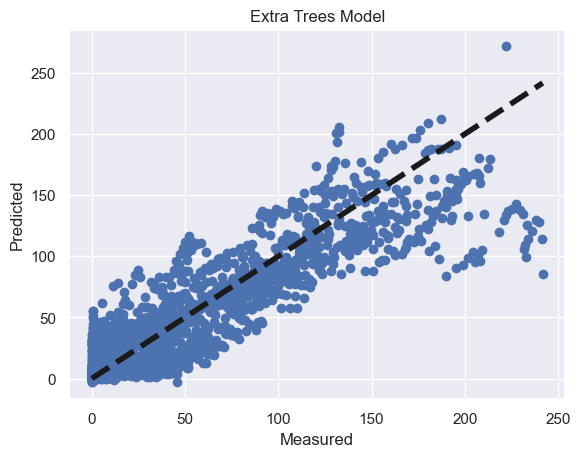

In [78]:
#plotting predictions v. actuals for Extra Trees Model
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Extra Trees Model')
plt.show()


#### 4.1.2 Hold-out Validation

In [31]:
# Predictions for hold-out validation set
y_pred_validate=model.predict(X_validate)
# Regression metrics
MAE_hov=mean_absolute_error(y_validate,y_pred_validate)
R2_hov=r2_score(y_validate,y_pred_validate)
RMSE_hov=np.sqrt(MSE(y_validate,y_pred_validate))

#### 4.1.3 Store Model Stats

In [76]:
stats=[R2_test,MAE_cv,MAE_std_cv,RMSE_cv,R2_cv,MAE_hov,RMSE_hov,R2_hov]
stats.extend(f_importance)
stats = pd.Series(stats)
df_modelstats[deathmodel]=stats
df_modelstats

,Metric,Deaths_Indoor_ExTr,Deaths_Indoor_RF,Deaths_Indoor_XGB
0,R2_train,0.817950,0.832437,0.808748
1,MAE_cv,35.492648,31.894792,30.722234
2,MAE_std_cv,1.931522,2.017405,30.722234
3,RMSE_cv,23.472385,22.531641,24.067570
4,R2_cv,0.818048,0.832341,0.808704
5,MAE_hov,21.011388,22.157319,21.901750
6,RMSE_hov,30.543183,32.698864,31.832830
7,R2_hov,0.755938,0.720272,0.734893
8,Year_importance,0.031899,0.044752,0.028067
9,GDP_pCapita_importance,0.071176,0.234135,0.160786


We can see the statistics are in line with what was tested in pycaret for Random Forest and Extra Tree Regressors. The cross-validation and hold-out validation provide similar r2 scores of 0.7 to 0.8, which is an indication that the model is not overfitting. Note that PyCaret was able to achieve higher score in some instances only where it increased the training data set size.

As determined in the earlier analysis using PyCaret - the largest importance is placed on the Social-Demographic Index.  Running the model several times gives different weights to the income_class_importance followed byminor contributions of the GDP per Capita and population.

### 4.2 Random Forest Regressor

According to internet various internet sources, Extra Trees seem to be more robust and less computationally expensive than Random Forests, however PyCaret did suggest that Random Forest provided the best model for predicting deaths due to outdoor PM2.5 and indoor pollution

**Note** As with Extra Trees Regressor - the data is not scaled

In [34]:
#Current Environmental Factor Death being predicted
deathmodel='Deaths_Indoor_RF'

In [35]:
# Initialize the model
model = RandomForestRegressor(n_estimators = 100,
          criterion ='mae',max_depth=7, max_features = "auto",n_jobs=-1)
# n_estimators = number of trees to build
# Criterion = MAE as MSE is more susceptible to outliers
# max_depth = 7 as we see that the number of levels in the tree did not need to be too large to 
# get decent results without overfitting
# If “auto”,  max_features=n_features on regression problems - this is acceptable 
# n_jobs=-1 to run in parallel set to number of available cores

Using the preliminary model from PyCaret: <br>
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7671, verbose=0, warm_start=False)
                      <Br>
    note that the model has not yet been tuned

In [36]:
#Train model on training set
model_fit=model.fit(X_train, y_train)

In [37]:
# Feature Importance store in a df
f_importance = model.feature_importances_

In [38]:
# Get performance metrics
R2_test=model.score(X_test,y_test)

In [39]:
# Make predictions for test data
y_pred=model.predict(X_test)
predictions = [round(value) for value in y_pred]

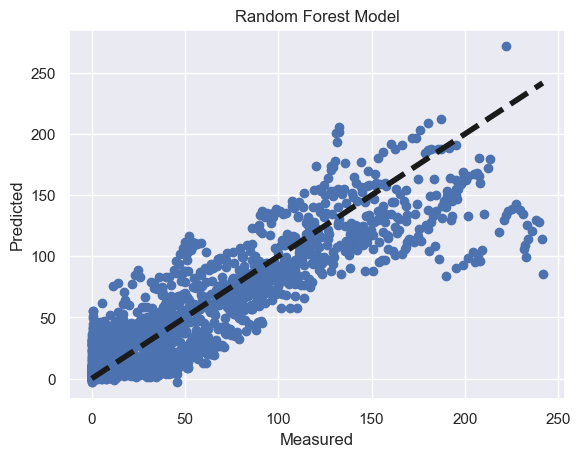

In [79]:
#plotting predictions v. actuals for Random Forest Model
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('Random Forest Model')
plt.show()

#### 4.2.1 Cross-Validation - k-folds=10

In [40]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_fit, X_cv, y_cv, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

In [41]:
# force scores to be positive
scores = absolute(scores)
MAE_cv=scores.mean()
MAE_std_cv=scores.std()
# RMSE Computation
RMSE_cv = np.sqrt(MSE(y_test, predictions))
# R2
R2_cv = r2_score(y_test, predictions)

#### 4.2.2 Hold-out Validation

In [42]:
# Predictions for hold-out validation set
y_pred_validate=model.predict(X_validate)
# Regression metrics
MAE_hov=mean_absolute_error(y_validate,y_pred_validate)
R2_hov=r2_score(y_validate,y_pred_validate)
RMSE_hov=np.sqrt(MSE(y_validate,y_pred_validate))

#### 4.2.3 Store Model Stats

In [77]:
stats=[R2_test,MAE_cv,MAE_std_cv,RMSE_cv,R2_cv,MAE_hov,RMSE_hov,R2_hov]
stats.extend(f_importance)
stats = pd.Series(stats)
df_modelstats[deathmodel]=stats
df_modelstats

,Metric,Deaths_Indoor_ExTr,Deaths_Indoor_RF,Deaths_Indoor_XGB
0,R2_train,0.817950,0.832437,0.808748
1,MAE_cv,35.492648,31.894792,30.722234
2,MAE_std_cv,1.931522,2.017405,30.722234
3,RMSE_cv,23.472385,22.531641,24.067570
4,R2_cv,0.818048,0.832341,0.808704
5,MAE_hov,21.011388,22.157319,21.901750
6,RMSE_hov,30.543183,32.698864,31.832830
7,R2_hov,0.755938,0.720272,0.734893
8,Year_importance,0.031899,0.044752,0.028067
9,GDP_pCapita_importance,0.071176,0.234135,0.160786


Results are fairly similar to the Extra Tree regressor, except the weighting assigned to the income_class and SoDI between the two. R2 scores are around 0.65 to 0.75.

As determined in the earlier analysis using PyCaret - the largest importance is placed on the Social-Demographic Index. followed byminor contributions of the the GDP per Capita and population.

### 4.3 XGBoost Regressor + Boosting

Similar to the Extra Tree Regressor and Random Forest Regressor, XGBoost is built on decision trees.

**Note** As with Extra Trees Regressor - the data is not scaled

In [45]:
#Current Environmental Factor Death being predicted
deathmodel='Deaths_Indoor_XGB'

In [46]:
# Setup a data matrix to improve performance
data_dmatrix = xgboost.DMatrix(data=X_cv,label=y_cv)

In [47]:
# Initialize the model
model = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.15,
                max_depth = 7, n_estimators = 100)

# objective ='reg:squarederror' for regression problems
# booster by default is gbtree = tree-based model comparable, which want to compare
# learning_rate = 0.15, step-size shrinkage on the conservative side to prevent over-fitting
# Criterion = MAE as MSE is more susceptible to outliers
# max_depth = 7, we will keep this tree depth as with the othe rmodels
# get decent results without overfitting
# If “auto”,  max_features=n_features on regression problems - this is acceptable 
# n_jobs=-1 to run in parallel set to number of available cores
# colsample_bytree = 0.7, we will increase this to force the impact of more features being included

In [48]:
#Train model on training set
model_fit=model.fit(X_train, y_train)

In [49]:
# Feature Importance store in a df
f_importance = model.feature_importances_

In [50]:
# Get performance metrics
R2_test=model.score(X_test,y_test)

In [51]:
# Make predictions for test data
y_pred=model.predict(X_test)
predictions = [round(value) for value in y_pred]

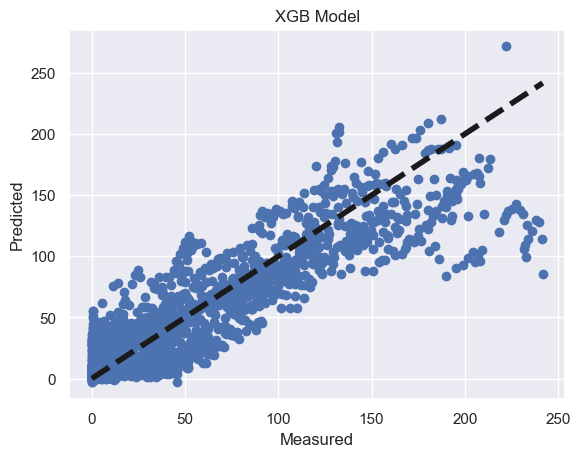

In [80]:
#plotting predictions v. actuals for XGB Model
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title('XGB Model')
plt.show()

#### 4.3.1 Cross-Validation - k-folds=10

In [52]:
# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
#scores = cross_val_score(model_fit, X_cv, y_cv, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
num_boosting_iter = 1000
cv = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=num_boosting_iter,early_stopping_rounds=None,metrics="mae", as_pandas=True, seed=123)

In [53]:
# force scores to be positive
#scores = absolute(scores)
MAE_cv=cv['train-mae-mean'].mean()
MAE_std_cv=cv['train-mae-mean'].mean()
# RMSE Computation
RMSE_cv = np.sqrt(MSE(y_test, predictions))
# R2
R2_cv = r2_score(y_test, predictions)

#### 4.3.2 Hold-out Validation

In [54]:
# Predictions for hold-out validation set
y_pred_validate=model.predict(X_validate)
# Regression metrics
MAE_hov=mean_absolute_error(y_validate,y_pred_validate)
R2_hov=r2_score(y_validate,y_pred_validate)
RMSE_hov=np.sqrt(MSE(y_validate,y_pred_validate))

#### 4.3.3 Store Model Stats

In [56]:
stats=[R2_test,MAE_cv,MAE_std_cv,RMSE_cv,R2_cv,MAE_hov,RMSE_hov,R2_hov]
stats.extend(f_importance)
stats = pd.Series(stats)
df_modelstats[deathmodel]=stats

The results are fairly close to the other tree models and more similar to Random Forest Results.

### 4.5 Comparing Individual ML Model Results

In [61]:
df_modelstats

,Metric,Deaths_Indoor_ExTr,Deaths_Indoor_RF,Deaths_Indoor_XGB
0,R2_train,0.817950,0.832437,0.808748
1,MAE_cv,35.492648,31.894792,30.722234
2,MAE_std_cv,1.931522,2.017405,30.722234
3,RMSE_cv,23.472385,22.531641,24.067570
4,R2_cv,0.818048,0.832341,0.808704
5,MAE_hov,21.011388,22.157319,21.901750
6,RMSE_hov,30.543183,32.698864,31.832830
7,R2_hov,0.755938,0.720272,0.734893
8,Year_importance,0.031899,0.044752,0.028067
9,GDP_pCapita_importance,0.071176,0.234135,0.160786


In [81]:
#extracting/transposing the necessary attributes and metrics from the stats model to graph R2, MAE and RMSE
new_df=df_modelstats.iloc[0:8].set_index('Metric').transpose()
new_df.index.name = 'Model'
new_df = new_df.reset_index()
new_df

Metric,Model,R2_train,MAE_cv,MAE_std_cv,RMSE_cv,R2_cv,MAE_hov,RMSE_hov,R2_hov
0,Deaths_Indoor_ExTr,0.817950,35.492648,1.931522,23.472385,0.818048,21.011388,30.543183,0.755938
1,Deaths_Indoor_RF,0.832437,31.894792,2.017405,22.531641,0.832341,22.157319,32.698864,0.720272
2,Deaths_Indoor_XGB,0.808748,30.722234,30.722234,24.067570,0.808704,21.901750,31.832830,0.734893


In [82]:
#extracting/transposing the necessary attributes and metrics from the stats model to graph R2, MAE and RMSE
new_df=df_modelstats.iloc[0:8].set_index('Metric').transpose()
new_df.index.name = 'Model'
new_df = new_df.reset_index()
new_df

Metric,Model,R2_train,MAE_cv,MAE_std_cv,RMSE_cv,R2_cv,MAE_hov,RMSE_hov,R2_hov
0,Deaths_Indoor_ExTr,0.817950,35.492648,1.931522,23.472385,0.818048,21.011388,30.543183,0.755938
1,Deaths_Indoor_RF,0.832437,31.894792,2.017405,22.531641,0.832341,22.157319,32.698864,0.720272
2,Deaths_Indoor_XGB,0.808748,30.722234,30.722234,24.067570,0.808704,21.901750,31.832830,0.734893


In [83]:
#extracting/transposing the necessary attributes and metrics from the stats model to graph importance
imp_df=df_modelstats.iloc[8:].set_index('Metric').transpose()
imp_df.index.name = 'Model'
imp_df = imp_df.reset_index()
imp_df

dfm = imp_df.melt('Model', var_name='Importance', value_name='Values')


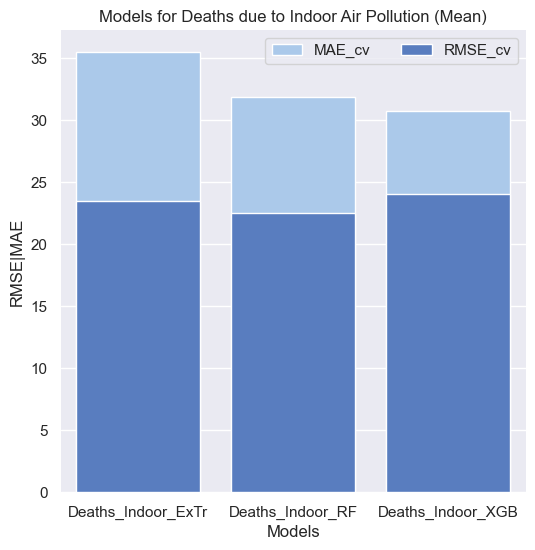

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Year_importance'),
  Text(1, 0, 'GDP_pCapita_importance'),
  Text(2, 0, 'Population_importance'),
  Text(3, 0, 'SoDI_importance'),
  Text(4, 0, 'Income_Class_importance')])

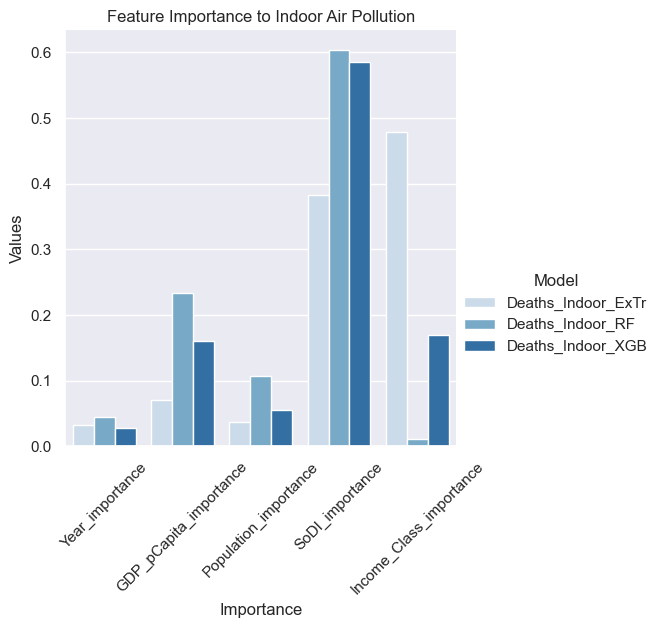

In [84]:
#plotting RMSE and MAE using seaborn
f, ax = plt.subplots(figsize = (6,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'Model', y = 'MAE_cv', data = new_df,
            label = 'MAE_cv', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'Model', y = 'RMSE_cv', data = new_df,
            label = 'RMSE_cv', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'upper right')
ax.set(xlabel='Models', ylabel='RMSE|MAE')
plt.title('Models for Deaths due to Indoor Air Pollution (Mean)')
sns.despine(left = True, bottom = True)
plt.show()

#plotting feature importance using seaborn
sns.catplot(x="Importance", y="Values", hue='Model', data=dfm, kind='bar',palette = 'Blues', edgecolor = 'w')
plt.title('Feature Importance to Indoor Air Pollution')
plt.xticks(rotation=45)

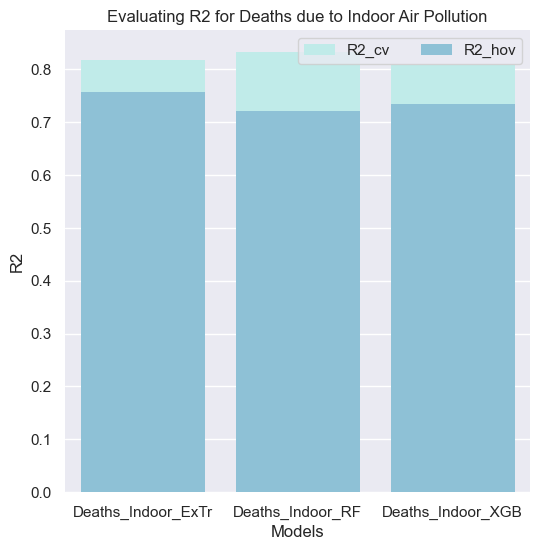

In [85]:
#plotting R2 using seaborn
f, ax = plt.subplots(figsize = (6,6))
sns.set_color_codes('pastel')
sns.barplot(x = 'Model', y = 'R2_cv', data = new_df,
            label = 'R2_cv', color = 'c', edgecolor = 'none')
sns.set_color_codes('muted')
sns.barplot(x = 'Model', y = 'R2_hov', data = new_df,
            label = 'R2_hov', color = 'c', edgecolor = 'none')
ax.legend(ncol = 2, loc = 'upper right')
ax.set(xlabel='Models', ylabel='R2')
plt.title('Evaluating R2 for Deaths due to Indoor Air Pollution')
sns.despine(left = True, bottom = True)
plt.show()

### 4.6 Ensembling the 3 Models

In [58]:
#get a voting ensemble of models
def get_voting():
    '''Voting ensemble method: define the base models: XGB, Random Forest and Extra Trees 
    Output = ensemble = voting regressor model
    '''
    models = [] #initialize
    #Setup models as with parameters discussed in previous sections before and append them into the list
    models.append(('XGB', XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.15,
                max_depth = 7, n_estimators = 100)))
    models.append(('RF', RandomForestRegressor(n_estimators = 100,
          criterion ='mae',max_depth=7, max_features = "auto",n_jobs=-1)))
    models.append(('ET', ExtraTreesRegressor(n_estimators = 100,
          criterion ='mae',max_depth=7, max_features = "auto",n_jobs=-1)))
    
    # define the voting ensemble
    ensemble = VotingRegressor(estimators=models)
    return ensemble

#get a list of models to then evaluate and compare
def get_models():
    '''get a list of models to then evaluate and compare
    Output = voting model result
    '''
    #Initialize a dictionary and store the regressors
    models = dict()
    models['XGB'] =  XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.7, learning_rate = 0.15,
                max_depth = 7, n_estimators = 100)
    models['RF'] = RandomForestRegressor(n_estimators = 100,
          criterion ='mae',max_depth=7, max_features = "auto",n_jobs=-1)
    models['ET'] = ExtraTreesRegressor(n_estimators = 100,
          criterion ='mae',max_depth=7, max_features = "auto",n_jobs=-1)
    #Return the voting score for each other models in the ensemble
    models['voting'] = get_voting()
    return models

#evaluate the models and return scores
def evaluate(model, X, y):
    '''valuate the models and return scores
    Output = cross validation score
    '''
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [59]:
#run functions, get models and store results
models = get_models()
results=[]
names=[]
for name, model in models.items():
    scores = evaluate(model, X_cv, y_cv)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>XGB -23.717 (1.029)
>RF -31.939 (1.961)
>ET -35.453 (1.891)
>voting -29.376 (1.593)


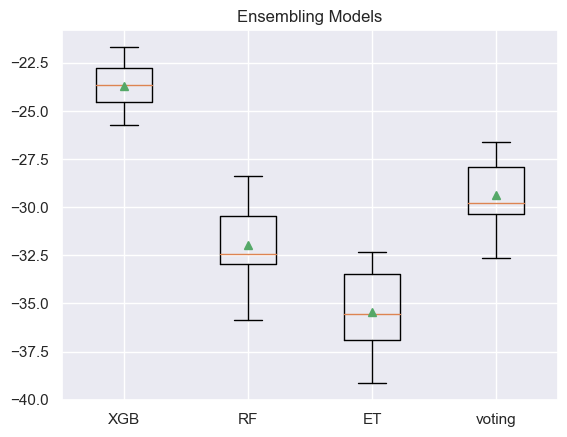

In [86]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
ax.set(xlabel='Models', ylabel='MAE')
plt.title('Ensembling Models')
pyplot.show()

### 4.7 Discussion

The tree regressors have similar performance and the voting method doesn't produce a model that is significantly better than any of the 3 individual models. These models can still offer some insight into the interaction of the socio-demographic/economic metrics and the deaths. Linear regression can be used alongside this as it preserves time-series relationships and can predict trends on a national or regional level, whereas the tree-based regressors link other other endogenous variables to environmental deaths.